In [251]:
import importlib
import io
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D

import multiprocessing as mp
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import scipy as sp
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
import staintools
from staintools import stain_normalizer, LuminosityStandardizer
from staintools.preprocessing.input_validation import is_uint8_image

import sys
import time
import timeit

In [2]:
# Import HEMnet package
BASE_DIR = Path().resolve().parent
HEMNET_DIR = BASE_DIR.joinpath('HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

In [177]:
# User Input parameters
DATASET_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Test_Datasets')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/29_07_20_testing')
TP53_PATH = DATASET_PATH.joinpath('test_dataset_10x_08_07_20_vahadane')
PATH_PATH = DATASET_PATH.joinpath('test_dataset_path_10x_25_06_20_vahadane')
TP53_RESULTS_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Results/figures_10x_23_07_20_strict_vahadane_224px/performance_matrix.csv')

ALIGNMENT_MAG = 2
TILE_MAG = 10
#Allow user to select between 'none', 'reinhard', 'macenko' and 'vahadane'
NORMALISER_METHOD = "vahadane"
STANDARDISE_LUMINOSITY = True
VERBOSE = True
NN_TILE_SIZE = 224
CNN_BASE = 'vgg16'

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

In [181]:
tp53_results = pd.read_csv(TP53_RESULTS_PATH, index_col = 0)

In [182]:
tp53_results

,accuracy,balanced_accuracy,roc_auc,precision,recall,fscore
1792_T_9500_2,0.660371,0.491404,0.512317,0.475035,0.491404,0.391689
1798_T_9514_2,0.886972,0.822709,0.898208,0.832005,0.822709,0.821459
1919_T_10779_2,0.710389,0.728138,0.842399,0.806013,0.728138,0.709667
1932_T_9876_2,0.723807,0.673418,0.736557,0.680454,0.673418,0.670203
1939_T_9661_2,0.692351,0.703488,0.778226,0.704283,0.703488,0.703200
2011_T_9699_2,0.884956,0.901015,0.966503,0.902269,0.901015,0.900938
2019_T_9717_2,0.572757,0.615118,0.676037,0.622679,0.615118,0.609094
2023_T_9727_2,0.852056,0.867876,0.952475,0.871104,0.867876,0.867588
2036_T_9729_2,0.477452,0.430943,0.381341,0.429574,0.430943,0.428163
2038_T_11986_2,0.613288,0.627660,0.706628,0.631558,0.627660,0.624880


In [174]:
tp53_cancer_tiles = [x.stem for x in TP53_PATH.joinpath('tiles_10x/cancer').glob('*.jpeg')]
tp53_noncancer_tiles = [x.stem for x in TP53_PATH.joinpath('tiles_10x/non-cancer').glob('*.jpeg')]

verbose_print(f'TP53 : Found {len(tp53_cancer_tiles)} cancer tiles and {len(tp53_noncancer_tiles)} noncancer tiles')

TP53 : Found 5288 cancer tiles and 10030 noncancer tiles


In [176]:
path_cancer_tiles = [x.stem for x in PATH_PATH.joinpath('tiles_10x/cancer').glob('*.jpeg')]
path_noncancer_tiles = [x.stem for x in PATH_PATH.joinpath('tiles_10x/non-cancer').glob('*.jpeg')]

verbose_print(f'Path : Found {len(path_cancer_tiles)} cancer tiles and {len(path_noncancer_tiles)} noncancer tiles')

Path : Found 10294 cancer tiles and 10622 noncancer tiles


In [57]:
tp53_cancer_df = pd.DataFrame(True, index = tp53_cancer_tiles, columns = ['TP53_Cancer'])
tp53_noncancer_df = pd.DataFrame(False, index = tp53_noncancer_tiles, columns = ['TP53_Cancer'])
tp53_df = pd.concat([tp53_cancer_df, tp53_noncancer_df], axis = 0)

In [58]:
path_cancer_df = pd.DataFrame(True, index = path_cancer_tiles, columns = ['Path_Cancer'])
path_noncancer_df = pd.DataFrame(False, index = path_noncancer_tiles, columns = ['Path_Cancer'])
path_df = pd.concat([path_cancer_df, path_noncancer_df], axis = 0)

In [93]:
combined_df = pd.concat([tp53_df, path_df], axis=1, join='inner')
combined_df.head()

,TP53_Cancer,Path_Cancer
1919_T_10779_2_25_64,True,True
2382_T_15360_2_54_68,True,True
2036_T_9729_2_6_60,True,False
2023_T_9727_2_59_21,True,True
1919_T_10779_2_34_43,True,True


In [94]:
excluded_tiles = len(tp53_df) + len(path_df) - 2 * len(combined_df)
verbose_print(f'{len(combined_df)} tiles were in both datasets, {excluded_tiles} tiles were not')

10314 tiles were in both datasets, 15606 tiles were not


In [95]:
tile_name_split = [x.split('_') for x in combined_df.index.values]
tile_locations = [f'{x[-2]}_{x[-1]}' for x in tile_name_split]
slide_names = [f'{x[0]}_{x[1]}_{x[2]}_{x[3]}' for x in tile_name_split]
combined_df['Location'] = tile_locations
combined_df['Slide'] = slide_names
combined_df = combined_df.set_index('Slide')
# combined_df(index = [np.array(slide_names), np.array(tile_locations)])

In [99]:
# pd.MultiIndex.from_frame(combined_df, names = ('Slide', 'Location'))

In [116]:
slide_names_unique = combined_df.index.unique()
len(slide_names_unique)

13

In [117]:
def plot_ROC(fpr, tpr, roc_auc, out_path):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(out_path, dpi=180)
    plt.close()

In [120]:
combined_df.TP53_Cancer.values

array([ True,  True,  True, ..., False, False, False])

In [143]:
pd.Series

pandas.core.series.Series

In [244]:
lst = [x for x in zip(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)]
lst2 = np.random.shuffle(zip(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values))

TypeError: object of type 'zip' has no len()

In [246]:
lst

[(True, True),
 (True, True),
 (False, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, True),
 (True, True),
 (False, True),
 (False, True),
 (False, True),
 (True, True),
 (True, True),
 (False, True),
 (True, True),
 (True, True),
 (False, True),
 (True, True),
 (False, True),
 (False, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, True),
 (True, True),
 (True, True),
 (True, True),
 (False, True),
 (True, True),
 (True, True),
 (False, True),
 (False, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, True),
 (True, True),
 (False, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, Tr

In [247]:
# def balanced_accuracy_score(true, pred):
#     repetitions = 10
#     accuracy = []
#     zipped = [x for x in zip(true, pred)]
#     while repetitions > 0:
#         np.random.shuffle(zipped)
#         true_values = [true for true, pred in zipped]
#         pred_values = [pred for true, pred in zipped]
#         if len(true) > len(pred): 
#             true_values = true_values[0: len(pred)]
#         else:
#             pred_values = pred_values[0 : len(true)]
#         accuracy.append(accuracy_score(true_values, pred_values))
#     return np.mean(np.array(accuracy))
        

In [252]:
performance_df = pd.DataFrame(columns = ['ACC', 'BACC', 'FPR', 'TPR', 'AUC'])
for name in slide_names_unique:
    slide_df = combined_df.loc[name]
    acc = accuracy_score(slide_df.Path_Cancer.values, slide_df.TP53_Cancer.values)
    balanced_acc = balanced_accuracy_score(slide_df.Path_Cancer.values, slide_df.TP53_Cancer.values)
    fpr, tpr, _ = roc_curve(slide_df.Path_Cancer.values, slide_df.TP53_Cancer.values)
    roc_auc = auc(fpr, tpr)
    slide_performance = pd.Series({'ACC' : acc, 'BACC': balanced_acc, 'FPR' : fpr, 'TPR' : tpr, 'AUC' : roc_auc}, name = name)
    performance_df = performance_df.append(slide_performance)

performance_df = performance_df.sort_values(by=['AUC'], ascending = False)

acc = accuracy_score(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)
balanced_acc = balanced_accuracy_score(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)
fpr, tpr, _ = roc_curve(combined_df.Path_Cancer.values, combined_df.TP53_Cancer.values)
roc_auc = auc(fpr, tpr)
all_slide_performance = pd.Series({'ACC' : acc, 'BACC': balanced_acc, 'FPR' : fpr, 'TPR' : tpr, 'AUC' : roc_auc}, name = 'All Slides')
performance_df = performance_df.append(all_slide_performance)

In [253]:
performance_df

,ACC,BACC,FPR,TPR,AUC
2023_T_9727_2,0.927823,0.887668,"[0.0, 0.039097744360902256, 1.0]","[0.0, 0.8144329896907216, 1.0]",0.887668
2075_T_9787_2,0.820896,0.820509,"[0.0, 0.17681159420289855, 1.0]","[0.0, 0.8178294573643411, 1.0]",0.820509
1919_T_10779_2,0.702183,0.809872,"[0.0, 0.004149377593360996, 1.0]","[0.0, 0.6238938053097345, 1.0]",0.809872
232_T_13230_2,0.801026,0.790370,"[0.0, 0.23308270676691728, 1.0]","[0.0, 0.8138222849083215, 1.0]",0.790370
1798_T_9514_2,0.876959,0.758262,"[0.0, 0.10304054054054054, 1.0]","[0.0, 0.6195652173913043, 1.0]",0.758262
2038_T_11986_2,0.798817,0.737792,"[0.0, 0.3333333333333333, 1.0]","[0.0, 0.8089171974522293, 1.0]",0.737792
2011_T_9699_2,0.753165,0.728148,"[0.0, 0.34, 1.0]","[0.0, 0.7962962962962963, 1.0]",0.728148
1939_T_9661_2,0.680180,0.650422,"[0.0, 0.27892234548335976, 1.0]","[0.0, 0.5797665369649806, 1.0]",0.650422
2382_T_15360_2,0.608451,0.622620,"[0.0, 0.09792284866468842, 1.0]","[0.0, 0.34316353887399464, 1.0]",0.622620
2019_T_9717_2,0.554815,0.602834,"[0.0, 0.2626728110599078, 1.0]","[0.0, 0.4683406113537118, 1.0]",0.602834


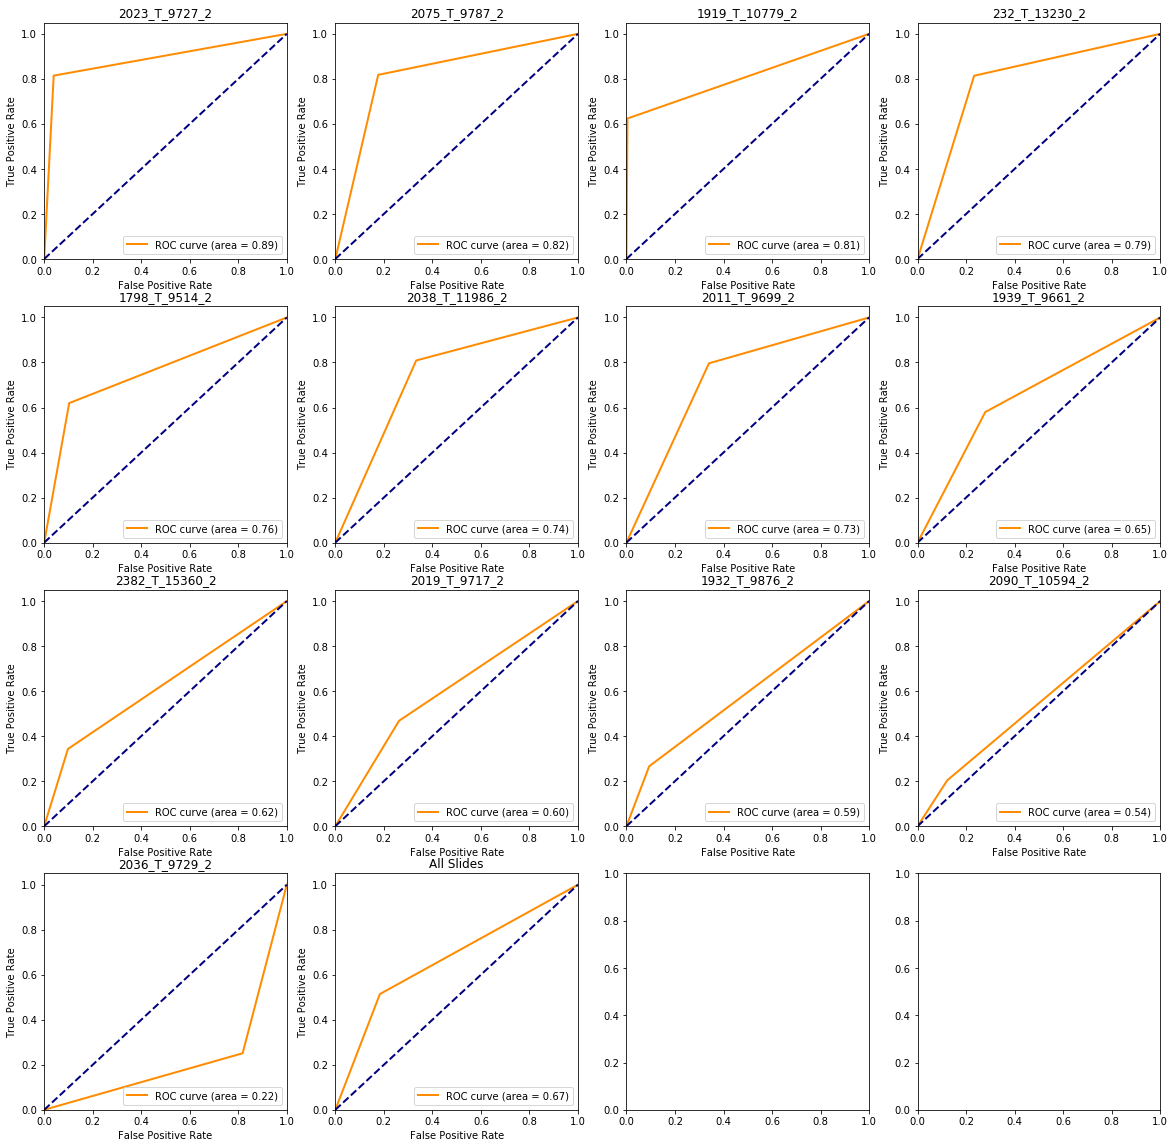

In [254]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (20,20))
lw = 2
for i, name in enumerate(performance_df.index):
    ax = axs[(i - i % 4) // 4, i % 4]
    fpr, tpr, roc_auc = performance_df.loc[name][['FPR', 'TPR', 'AUC']]
    ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_title(name)

In [261]:
tp53_results_performance_df = pd.concat([tp53_results, performance_df], axis=1, join='inner')
tp53_results_performance_df

,accuracy,balanced_accuracy,roc_auc,precision,recall,fscore,ACC,BACC,FPR,TPR,AUC
1798_T_9514_2,0.886972,0.822709,0.898208,0.832005,0.822709,0.821459,0.876959,0.758262,"[0.0, 0.10304054054054054, 1.0]","[0.0, 0.6195652173913043, 1.0]",0.758262
1919_T_10779_2,0.710389,0.728138,0.842399,0.806013,0.728138,0.709667,0.702183,0.809872,"[0.0, 0.004149377593360996, 1.0]","[0.0, 0.6238938053097345, 1.0]",0.809872
1932_T_9876_2,0.723807,0.673418,0.736557,0.680454,0.673418,0.670203,0.315663,0.586284,"[0.0, 0.09375, 1.0]","[0.0, 0.26631853785900783, 1.0]",0.586284
1939_T_9661_2,0.692351,0.703488,0.778226,0.704283,0.703488,0.703200,0.680180,0.650422,"[0.0, 0.27892234548335976, 1.0]","[0.0, 0.5797665369649806, 1.0]",0.650422
2011_T_9699_2,0.884956,0.901015,0.966503,0.902269,0.901015,0.900938,0.753165,0.728148,"[0.0, 0.34, 1.0]","[0.0, 0.7962962962962963, 1.0]",0.728148
2019_T_9717_2,0.572757,0.615118,0.676037,0.622679,0.615118,0.609094,0.554815,0.602834,"[0.0, 0.2626728110599078, 1.0]","[0.0, 0.4683406113537118, 1.0]",0.602834
2023_T_9727_2,0.852056,0.867876,0.952475,0.871104,0.867876,0.867588,0.927823,0.887668,"[0.0, 0.039097744360902256, 1.0]","[0.0, 0.8144329896907216, 1.0]",0.887668
2036_T_9729_2,0.477452,0.430943,0.381341,0.429574,0.430943,0.428163,0.224163,0.216676,"[0.0, 0.8178438661710037, 1.0]","[0.0, 0.2511961722488038, 1.0]",0.216676
2038_T_11986_2,0.613288,0.627660,0.706628,0.631558,0.627660,0.624880,0.798817,0.737792,"[0.0, 0.3333333333333333, 1.0]","[0.0, 0.8089171974522293, 1.0]",0.737792
2075_T_9787_2,0.710087,0.729308,0.826080,0.729532,0.729308,0.729242,0.820896,0.820509,"[0.0, 0.17681159420289855, 1.0]","[0.0, 0.8178294573643411, 1.0]",0.820509


In [264]:
tp53_results_performance_df.columns

Index(['accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall',
       'fscore', 'ACC', 'BACC', 'FPR', 'TPR', 'AUC'],
      dtype='object')

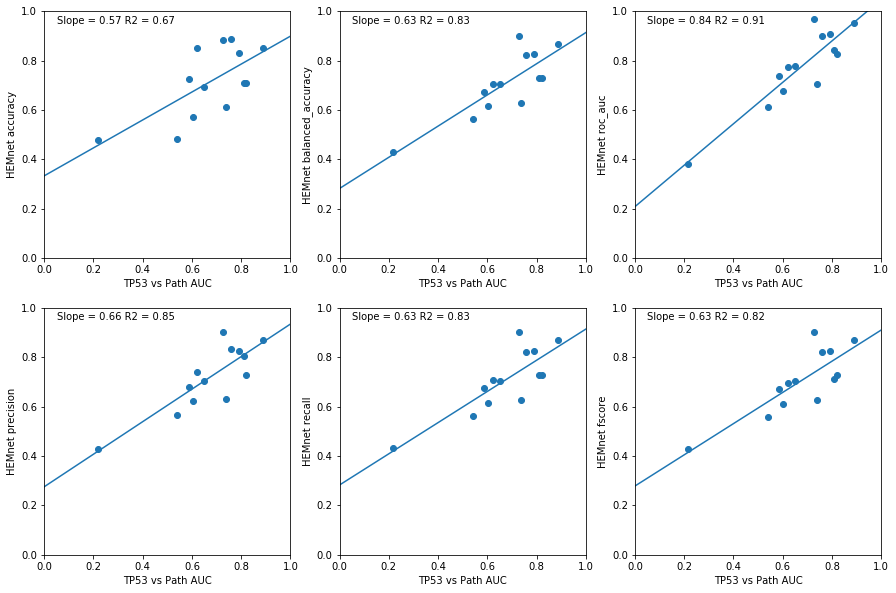

In [270]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
columns = ['accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall', 'fscore']
x_values = tp53_results_performance_df['AUC'].values
for i, column in enumerate(columns):
    ax = axs.ravel()[i]
    y_values = tp53_results_performance_df[column].values
    ax.scatter(x_values, y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50))
    ax.text(0.05 , 0.95 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f}')
    ax.set_xlabel('TP53 vs Path AUC')
    ax.set_ylabel(f'HEMnet {column}')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

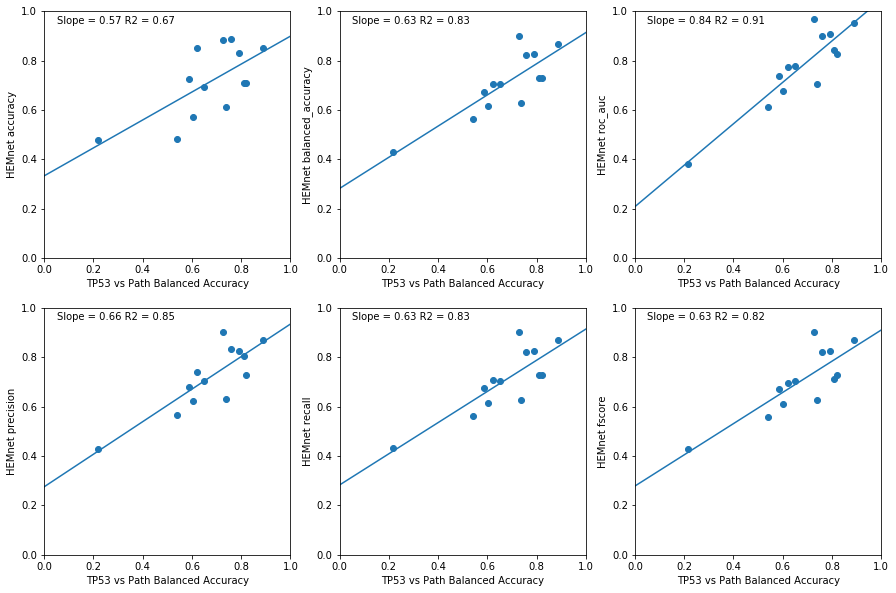

In [273]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
columns = ['accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall', 'fscore']
x_values = tp53_results_performance_df['BACC'].values
for i, column in enumerate(columns):
    ax = axs.ravel()[i]
    y_values = tp53_results_performance_df[column].values
    ax.scatter(x_values, y_values)
    linreg = sp.stats.linregress(x_values, y_values)
    ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50))
    ax.text(0.05 , 0.95 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f}')
    ax.set_xlabel('TP53 vs Path Balanced Accuracy')
    ax.set_ylabel(f'HEMnet {column}')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

(0, 1)

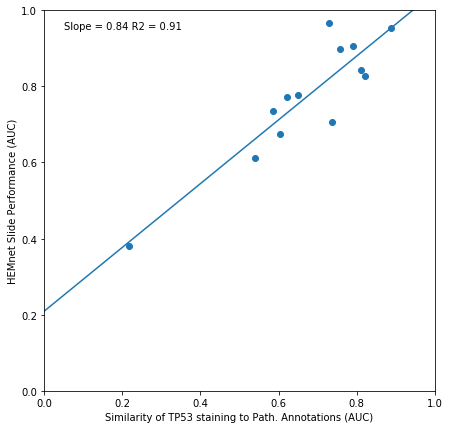

In [262]:
fig, ax = plt.subplots(figsize = (7,7))
y_values = tp53_results_performance_df['roc_auc'].values
x_values = tp53_results_performance_df['AUC'].values
ax.scatter(x_values, y_values)
linreg = sp.stats.linregress(x_values, y_values)
ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50))
ax.text(0.05 , 0.95 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f}')
ax.set_xlabel('Similarity of TP53 staining to Path. Annotations (AUC)')
ax.set_ylabel('HEMnet Slide Performance (AUC)')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

(0, 1)

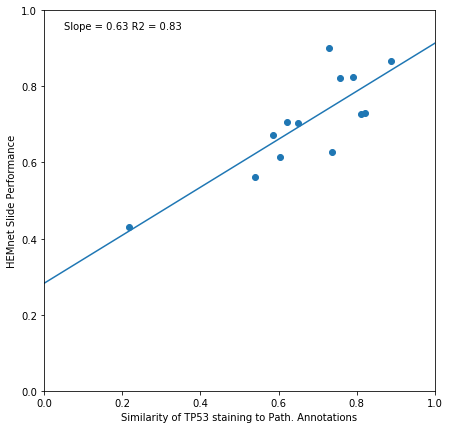

In [263]:
fig, ax = plt.subplots(figsize = (7,7))
y_values = tp53_results_performance_df['balanced_accuracy'].values
x_values = tp53_results_performance_df['BACC'].values
ax.scatter(x_values, y_values)
linreg = sp.stats.linregress(x_values, y_values)
ax.plot(np.linspace(0,1, 50), linreg.intercept + linreg.slope * np.linspace(0,1, 50))
ax.text(0.05 , 0.95 , f'Slope = {linreg.slope :.2f} R2 = {linreg.rvalue :.2f}')
ax.set_xlabel('Similarity of TP53 staining to Path. Annotations')
ax.set_ylabel('HEMnet Slide Performance')
ax.set_xlim(0,1)
ax.set_ylim(0,1)